In [1]:
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt
class STP(bp.synapses.TwoEndConn):
    def __init__(self, pre, post, conn, g_max=0.1, U=0.15, tau_f=1500., tau_d=200., tau=8., E=1., delay_step=2,
                 method='exp_auto', syn_type='CUBA', **kwargs):
        super(STP, self).__init__(pre=pre, post=post, conn=conn)
        # 初始化参数
        self.tau_d = tau_d
        self.tau_f = tau_f
        self.tau = tau
        self.U = U
        self.g_max = g_max
        self.E = E
        self.delay_step = delay_step
        self.type = syn_type
        # 获取每个连接的突触前神经元pre_ids和突触后神经元post_ids
        self.pre_ids, self.post_ids = self.conn.require('pre_ids', 'post_ids')

        # 初始化变量
        num = len(self.pre_ids)
        self.x = bm.Variable(bm.ones(num))
        self.u = bm.Variable(bm.zeros(num))
        self.g = bm.Variable(bm.zeros(num))
        self.delay = bm.LengthDelay(self.g, delay_step)  # 定义一个处理g的延迟器

        # 定义积分函数
        self.integral = bp.odeint(method=method, f=self.derivative)

    @property
    def derivative(self):
        du = lambda u, t: -u / self.tau_f
        dx = lambda x, t: (1 - x) / self.tau_d
        dg = lambda g, t: -g / self.tau
        return bp.JointEq([du, dx, dg])

    def update(self):
        # 更新各个变量
        syn_sps = bm.pre2syn(self.pre.spike, self.pre_ids)  # 哪些突触前神经炎产生了脉冲
        u, x, g = self.integral(self.u, self.x, self.g, bp.share['t'], bm.dt)
        u = bm.where(syn_sps, u + self.U * (1 - self.u), u)  # 更新后的u
        x = bm.where(syn_sps, x - u * self.x, x)  # 更新后的x
        g = bm.where(syn_sps, g + self.g_max * u * self.x, g)  # 更新后的g
        self.u.value = u
        self.x.value = x
        self.g.value = g
        # 更新延迟器
        self.delay.update(self.g)
        # 将g的计算延迟delay_step的时间步长
        delayed_g = self.delay(self.delay_step)
        # 计算突触后电流
        post_g = bm.syn2post(delayed_g, self.post_ids, self.post.num)
        self.post.input += post_g * (self.E - self.post.V_rest)


c:\Users\13107\.conda\envs\brainpy\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Day-4: 基础作业  
## 1. Run STP with pre- and post- neuron modelled as LIF neuron

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Predict 3000 steps: : 100%|██████████| 3000/3000 [00:00<00:00, 9881.93it/s]


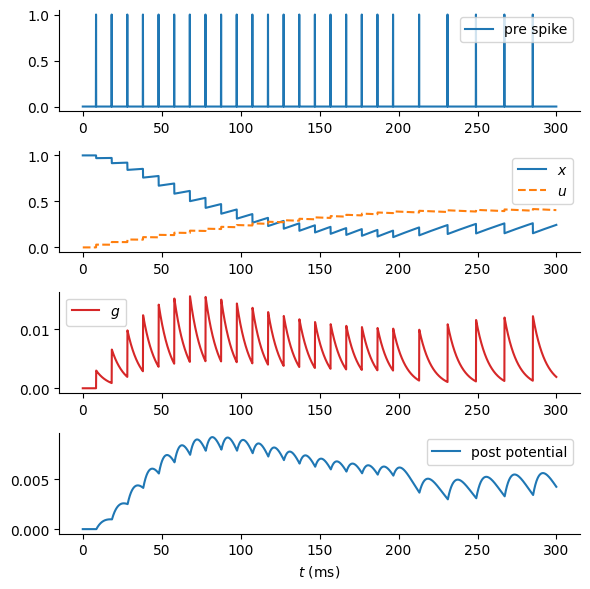

In [2]:
def run_STP(inputs, dur, tau_d = 130., tau_f = 530., U=0.03):
  # TO DO: 定义突触前神经元、突触后神经元和突触连接，并构建神经网络
  neu1 = bp.neurons.LIF(1)
  neu2 = bp.neurons.LIF(1)
  syn = STP(neu1, neu2, bp.connect.All2All(), tau_d = tau_d, tau_f = tau_f, U=U)
  net = bp.Network(pre=neu1, syn=syn, post=neu2)
  # TO DO, 将input设置为pre-synaptic neuron的输入，设置DSRunner运行模拟
  runner = bp.DSRunner(net,
                           inputs=[('pre.input', inputs, 'iter')],
                           monitors=['syn.u', 'syn.x', 'syn.g','pre.spike','post.V'])
  runner.run(dur)

  # 可视化
    
  fig, ax = plt.subplots(4, 1, figsize=(6, 6))
  ax[0].plot(runner.mon.ts, runner.mon['pre.spike'][:, 0], label='pre spike')
  ax[0].legend()
  ax[0].spines['top'].set_visible(False)
  ax[0].spines['right'].set_visible(False)

  ax[1].plot(runner.mon.ts, runner.mon['syn.x'][:, 0], label=r'$x$')
  ax[1].plot(runner.mon.ts, runner.mon['syn.u'][:, 0], label=r'$u$', linestyle='--')
  ax[1].legend()
  ax[1].spines['top'].set_visible(False)
  ax[1].spines['right'].set_visible(False)

  ax[2].plot(runner.mon.ts, runner.mon['syn.g'][:, 0], label=r'$g$', color=u'#d62728')
  ax[2].legend()
  ax[2].spines['top'].set_visible(False)
  ax[2].spines['right'].set_visible(False)
    
  ax[3].plot(runner.mon.ts, runner.mon['post.V'][:, 0], label='post potential')
  ax[3].spines['top'].set_visible(False)
  ax[3].spines['right'].set_visible(False)
  ax[3].legend()

  plt.xlabel(r'$t$ (ms)')
  plt.tight_layout()
  plt.show()

# Run the model
# 设置输入到突触前（分段）电流
I0 = 35.
I1 = 25.
T0 = 200.
T1 = 100.
inputs, dur = bp.inputs.section_input(values=[I0, I1],
                                    durations=[T0, T1],
                                    return_length=True) #设置电流20mA
run_STP(inputs = inputs, dur = dur)

## Answer 1

  0%|          | 0/3000 [00:00<?, ?it/s]

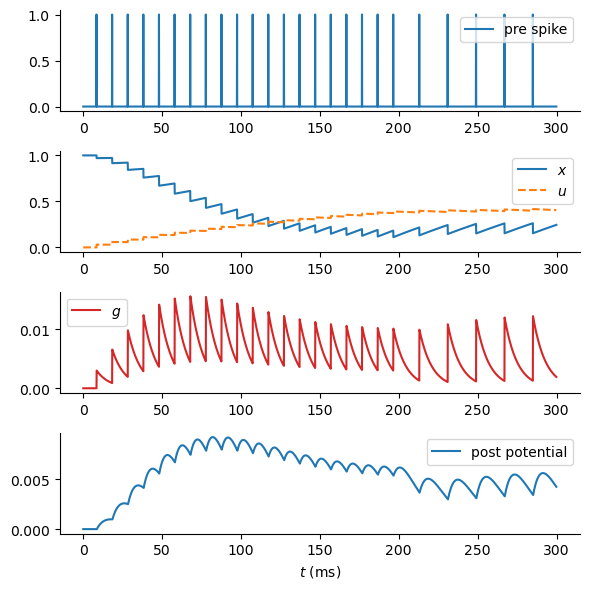

In [2]:
def run_STP(inputs, dur, tau_d = 130., tau_f = 530., U=0.03):
  # 定义突触前神经元、突触后神经元和突触连接，并构建神经网络
  neu1 = bp.neurons.LIF(1)
  neu2 = bp.neurons.LIF(1)
  syn = STP(neu1, neu2, bp.connect.All2All(), tau_d = tau_d, tau_f = tau_f, U=U)
  net = bp.Network(pre=neu1, syn=syn, post=neu2)
    
  # 运行模拟
  runner = bp.DSRunner(net,
                           inputs=[('pre.input', inputs, 'iter')],
                           monitors=['syn.u', 'syn.x', 'syn.g','pre.spike','post.V'])
  runner.run(dur)

  # 可视化
    
  fig, ax = plt.subplots(4, 1, figsize=(6, 6))
  ax[0].plot(runner.mon.ts, runner.mon['pre.spike'][:, 0], label='pre spike')
  ax[0].legend()
  ax[0].spines['top'].set_visible(False)
  ax[0].spines['right'].set_visible(False)

  ax[1].plot(runner.mon.ts, runner.mon['syn.x'][:, 0], label=r'$x$')
  ax[1].plot(runner.mon.ts, runner.mon['syn.u'][:, 0], label=r'$u$', linestyle='--')
  ax[1].legend()
  ax[1].spines['top'].set_visible(False)
  ax[1].spines['right'].set_visible(False)

  ax[2].plot(runner.mon.ts, runner.mon['syn.g'][:, 0], label=r'$g$', color=u'#d62728')
  ax[2].legend()
  ax[2].spines['top'].set_visible(False)
  ax[2].spines['right'].set_visible(False)
    
  ax[3].plot(runner.mon.ts, runner.mon['post.V'][:, 0], label='post potential')
  ax[3].spines['top'].set_visible(False)
  ax[3].spines['right'].set_visible(False)
  ax[3].legend()


  plt.xlabel(r'$t$ (ms)')
  plt.tight_layout()
  plt.show()

# 设置输入到突触前（分段）电流
I0 = 35.
I1 = 25.
T0 = 200.
T1 = 100.
inputs, dur = bp.inputs.section_input(values=[I0, I1],
                                    durations=[T0, T1],
                                    return_length=True) #设置电流20mA
run_STP(inputs = inputs, dur = dur)

## 2. Adjust the time constants to replicate short-term depression and short-term facilitation phenomenoa

Predict 10000 steps: : 100%|██████████| 10000/10000 [00:00<00:00, 29368.01it/s]


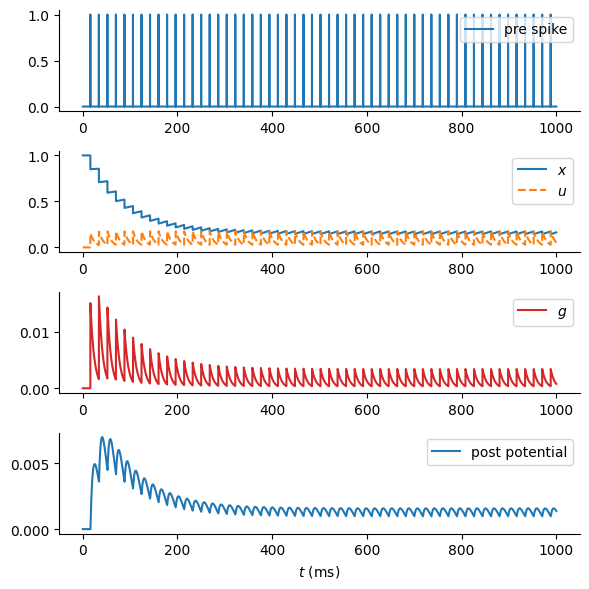

In [4]:
# 设置输入到突触前（分段）电流
I0 = 25.
T0 = 1000.
tau_d = 500.
tau_f = 10.
U = 0.15
inputs, dur = bp.inputs.section_input(values=[I0],
                                    durations=[T0],
                                    return_length=True) #设置电流20mA
run_STP(inputs = inputs, dur = dur, tau_d = tau_d, tau_f = tau_f, U=U)

In [8]:
# 设置输入到突触前（分段）电流
I0 = 25.
T0 = 1000.
tau_d = 500.
tau_f = 10.
U = 0.15
inputs, dur = bp.inputs.section_input(values=[I0],
                                    durations=[T0],
                                    return_length=True) #设置电流20mA
run_STP(inputs = inputs, dur = dur, tau_d = tau_d, tau_f = tau_f,U=U)

  0%|          | 0/10000 [00:00<?, ?it/s]

<Figure size 432x432 with 4 Axes>